# Main Goals

>  The main goal of this notebook is the comprehensive selection, tuning, and training of the best regression models for predicting goal counts. Models will be used to generate predictions for the top scorers for the current 2025/26 season. The analysis and forecasts are leaded in the context of the current league situation, after the 11th matchweek of the Premier League.
>
 ### Source

> The methodological approach and analysis process in this notebook were inspired by on the following research paper:
>
> [Diverse Machine Learning for Forecasting Goal-Scoring Likelihood in Elite Football Leagues](https://www.researchgate.net/publication/382812235_Diverse_Machine_Learning_for_Forecasting_Goal-Scoring_Likelihood_in_Elite_Football_Leagues)

***3/3***


In [ ]:
!pip install optuna-integration[sklearn]
!pip install -U optuna optuna-integration
!pip install -U optuna optuna-integration xgboost
!pip install catboost

In [134]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import statsmodels.formula.api as smf
import statsmodels.api as sm

from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution
from optuna.integration import OptunaSearchCV
from catboost import CatBoostRegressor

from optuna.pruners import MedianPruner
from optuna.integration.xgboost import XGBoostPruningCallback
from lightgbm import LGBMRegressor
from sklearn.svm import SVR

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import warnings
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")


warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [135]:
path="https://raw.githubusercontent.com/ruus77/Portfolio/refs/heads/main/PL_best_scorer/PL_1920_2526.csv"
df = pd.read_csv(path)
df = df.sort_values(by=["team", "season"])
df.drop(columns="Unnamed: 0", inplace=True)
df.head()

,league,season,team,player,league_id,season_id,team_id,player_id,position,matches,minutes,goals,xg,np_goals,np_xg,assists,xa,shots,key_passes,yellow_cards,red_cards,xg_chain,xg_buildup,previous_season_position,is_in_europe,lagged_mpm_1,lagged_fmp_1,lagged_xg_perf_1,lagged_npxg_perf_1,lagged_xg_per_shot_1,lagged_penalty_taker_1,lagged_g90_1,lagged_a90_1,lagged_ga90_1,lagged_xg90_1,lagged_xa90_1,lagged_goals_1,lagged_mpm_2,lagged_fmp_2,lagged_xg_perf_2,lagged_npxg_perf_2,lagged_xg_per_shot_2,lagged_penalty_taker_2,lagged_g90_2,lagged_a90_2,lagged_ga90_2,lagged_xg90_2,lagged_xa90_2,lagged_goals_2,main_pos,position_1,position_2,position_3,position_4
85,ENG-Premier League,1920,Arsenal,ainsley maitland-niles,1,2019,83,1750,D S,20,1372,0.0,0.508408,0,0.508408,2,1.646097,4,11,4,1,5.156502,3.567148,5.0,1.0,60.826087,7.688889,-0.401947,-0.401947,0.038172,0.0,0.000000,0.000000,0.000000,0.013581,0.009722,0.0,60.826087,7.688889,-0.401947,-0.401947,0.038172,0.0,0.000000,0.000000,0.000000,0.013581,0.009722,0.0,1,1,0,0,0
137,ENG-Premier League,1920,Arsenal,alexandre lacazette,1,2019,83,3277,F S,30,1890,10.0,8.664644,10,8.664644,4,3.342293,52,24,8,0,12.061310,2.505634,5.0,1.0,31.547101,5.322222,-1.946718,-1.990343,0.125597,0.0,0.149728,0.000000,0.256184,0.302738,0.065931,1.0,31.547101,5.322222,-1.946718,-1.990343,0.125597,0.0,0.149728,0.000000,0.256184,0.302738,0.065931,1.0,3,0,0,1,0
421,ENG-Premier League,1920,Arsenal,bernd leno,1,2019,83,181,GK,30,2649,0.0,0.000000,0,0.000000,0,0.000000,0,0,2,0,4.038204,4.038204,5.0,1.0,90.000000,4.250000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,90.000000,4.250000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0,0,0,0
502,ENG-Premier League,1920,Arsenal,bukayo saka,1,2019,83,7322,D F M S,26,1769,1.0,1.142438,1,1.142438,5,3.680353,13,21,6,0,7.812512,5.022922,5.0,1.0,51.383333,12.005556,-1.373554,-1.373554,0.071989,0.0,0.050042,0.082329,0.175781,0.096436,0.094520,1.0,51.383333,12.005556,-1.373554,-1.373554,0.071989,0.0,0.050042,0.082329,0.175781,0.096436,0.094520,1.0,3,0,0,1,0
534,ENG-Premier League,1920,Arsenal,calum chambers,1,2019,83,508,D S,14,1102,1.0,0.632950,1,0.632950,1,2.241444,12,7,5,0,4.406148,3.210470,5.0,1.0,60.826087,7.688889,-0.401947,-0.401947,0.038172,0.0,0.000000,0.000000,0.000000,0.013581,0.009722,0.0,60.826087,7.688889,-0.401947,-0.401947,0.038172,0.0,0.000000,0.000000,0.000000,0.013581,0.009722,0.0,1,1,0,0,0


In [136]:
teams_names = list(df.team.unique())

In [137]:
teams_endocer = LabelEncoder()
teams_endocer.fit(teams_names)

LabelEncoder()

In [138]:
df["team_labeled"] = teams_endocer.transform(df["team"])
df["goals_trend"] = df.lagged_goals_1 - df.lagged_goals_2

In [139]:
df = df[df.goals > 2]

In [140]:
cols_to_drop = ["season", "team", "player", "position", "main_pos",
                "season_id", "np_goals", "team_id", "player_id", "league", "league_id"]


In [141]:
leaking_cols = ["matches", "minutes", "xg", "np_goals", "np_xg", "assists", "xa", "shots", "key_passes", "yellow_cards", "red_cards", "xg_chain", "xg_buildup"]

# Modeling Preparation

Data was split into training and testing sets. Two feature sets (`datasets`) were created based on correlation analysis. This was done to find features correlated with the target (`goals`) and to manage **Multicollinearity**, where features are highly correlated with each other.

* `Case 1` : The 12 features with the highest absolute correlation to `goals` were selected. This method ignores multicollinearity.
* `Case 2` (Reduced Multicollinearity): Features were selected using the `reduce_multicollinearity` function (threshold `0.7`) to create a set less dependent on each other, which is crucial for linear models.

Following this, the explanatory variables (`features`) and target variable (`target`) were defined. The `datasets`, `X_train`, `X_test`, `y_train`, and `y_test` lists were created based on these two cases. **The training sets included data from the 19/20 to 23/24 seasons, while the test set consisted of data from the 24/25 season.** Finally, `TimeSeriesSplit` (`tscv`) was defined as the cross-validation strategy, which is essential for time-structured data.


On target variable `y` $log(y+1)$ was applied to deal with outliers.

<Axes: >

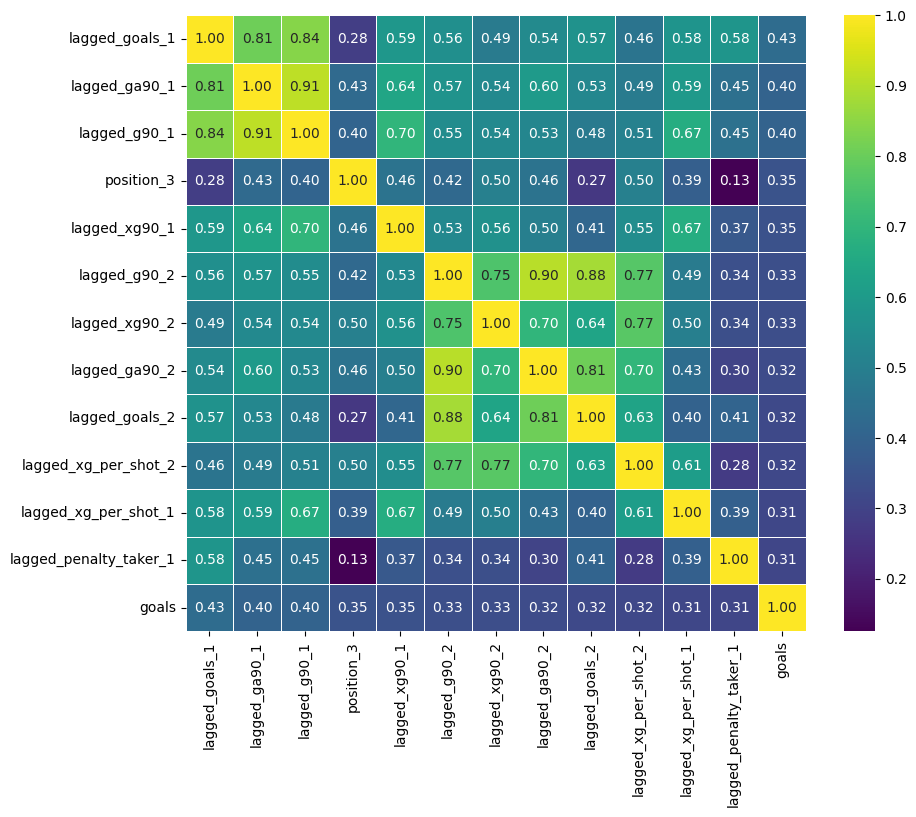

In [142]:
plt.figure(figsize=(10, 8))
case_1 = list((df.drop(cols_to_drop+leaking_cols, axis=1).corr().goals.apply(np.abs).sort_values(ascending=False).drop("goals").head(12)).index)

sns.heatmap(data=df[case_1+["goals"]].corr(), annot=True, fmt=".2f", cmap="viridis", linewidths=.5)

In [143]:
def reduce_multicollinearity(df: pd.DataFrame,
                           cols_to_drop: list,
                           target: str,
                           threshold: float):

    features = df.drop(cols_to_drop, axis=1)
    corr_mat = features.corr().abs()
    target_corr = corr_mat[target]

    upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
    high_corr_pairs = upper.stack()[upper.stack() > threshold].index

    to_drop = set()
    for feat1, feat2 in high_corr_pairs:
        if target_corr[feat1] < target_corr[feat2]:
            to_drop.add(feat1)
        else:
            to_drop.add(feat2)

    final_features = set(features.columns) - to_drop - {target}
    return list(final_features)

In [144]:
case_2 = reduce_multicollinearity(df=df,
                                  cols_to_drop=cols_to_drop+leaking_cols,
                                  target='goals',
                                  threshold=0.6)

case_2

['lagged_goals_1',
 'lagged_penalty_taker_1',
 'goals_trend',
 'previous_season_position',
 'team_labeled',
 'position_3',
 'lagged_g90_2',
 'lagged_fmp_1',
 'position_4',
 'lagged_npxg_perf_1',
 'position_1',
 'lagged_npxg_perf_2']

<Axes: >

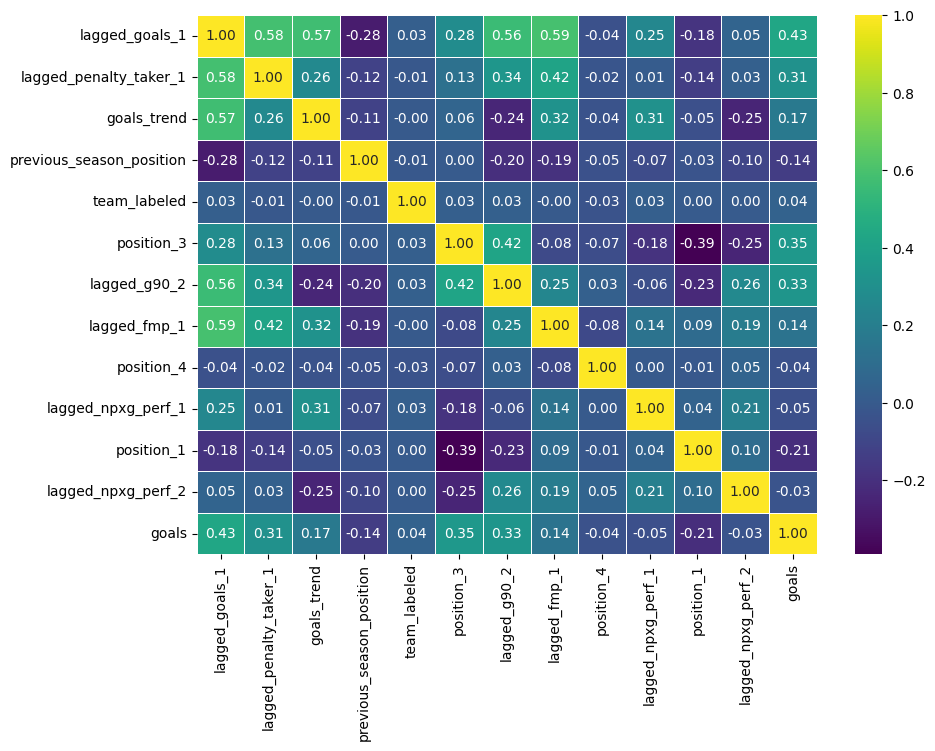

In [145]:
plt.figure(figsize=(10, 7))
sns.heatmap(data=df[case_2+["goals"]].corr(), annot=True, fmt=".2f", cmap="viridis", linewidths=.5)

In [147]:
df.season.unique()

array([1920, 2021, 2122, 2223, 2324, 2425, 2526])

In [148]:
train = ~df['season'].isin([2425, 2526])
test = df['season'].isin([2425])


In [149]:
X_case1 = df[case_1]
X_case2 = df[case_2]
X_case3 = df[case_3]
y = df.goals

train = ~df['season'].isin([2425, 2526])
test = df['season'].isin([2425])

X_case1_train = X_case1[train]
X_case1_test = X_case1[test]


X_case2_train = X_case2[train]
X_case2_test = X_case2[test]


X_case3_train = X_case3[train]
X_case3_test = X_case3[test]

y_train = y[train].apply(np.log1p)
y_test= y[test].apply(np.log1p)

# Model and Tuning

In this section, all models for the experiment were defined, along with their respective hyperparameter search spaces. A range of models was selected to compare different algorithmic approaches:
>
> * **Linear Models:** A simple `Linear Regression` was included to serve as a baseline. `Ridge` and `Lasso` were included because their built-in regularization is effective at managing multicollinearity and preventing overfitting.
> * **Non-linear & Ensemble Models:** `Support Vector Regression` and `Random Forest` were chosen to test if models that can capture complex, non-linear relationships would perform better.
> * **Boosting Model:** A gradient boosting model was included as the most complex.
>
> Finally, dictionaries (`best_estimators`, `best_params`) were initialized. These will be used in the next section to store the winning model, its best parameters, and its performance metrics for each experiment.

In [150]:
ridge = Ridge()
lasso = Lasso()

lr = LinearRegression()
rf = RandomForestRegressor(random_state=77, n_jobs=-1)
svr = SVR(kernel='rbf')


In [151]:
cat = CatBoostRegressor(random_state=77, verbose=0)

In [152]:
scaler = RobustScaler()
poly = PolynomialFeatures()

ridge_pipe = make_pipeline(poly, scaler , ridge)
lasso_pipe = make_pipeline(poly, scaler, lasso)
lr_pipe = make_pipeline(poly, scaler, lr)
svr_pipe = make_pipeline(scaler, svr)

In [153]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)


In [154]:
ridge_grid = {
#"polynomialfeatures__degree": IntDistribution(1, 3),
"ridge__alpha": FloatDistribution(30, 100.0, log=True)
}

lasso_grid = {
#"polynomialfeatures__degree": IntDistribution(1, 3),
"lasso__alpha": FloatDistribution(0.001, 10, log=True)
}

lr_grid= {"polynomialfeatures__degree": IntDistribution(1, 3)}

rf_grid = {
    'n_estimators': IntDistribution(100, 700, step=100),
    'max_depth': IntDistribution(10, 30),
    'min_samples_split': IntDistribution(4, 30),
    'max_features': CategoricalDistribution(['log2', 'sqrt'])
}

catboost_grid = {
    'iterations': IntDistribution(100, 600, step=50),
    'learning_rate': FloatDistribution(0.001, 0.05, log=True),
    'depth': IntDistribution(1, 6),
}

svr_grid = {
    'svr__C': FloatDistribution(0.1, 10.0, log=True)
}

In [155]:
linear_grids = [ridge_grid, lasso_grid, lr_grid, svr_grid, rf_grid, catboost_grid]


In [156]:
best_estimators = {
    "model_name" : [],
    "dataset" : [],
    "mse_train" : [],
    "mse_test" : [],
    "mae_train" : [],
    "mae_test" : []


    }
best_params = {
    "model_name" : [],
    "best_params" : [],
    "dataset" : []}

In [157]:
X_train = [X_case1_train,  X_case2_train]
X_test = [X_case1_test, X_case2_test]
datasets = ["case1", "case2"]

In [158]:
linear_models = [ridge_pipe, lasso_pipe, lr_pipe, svr_pipe, rf, cat]
linear_models_names = ["ridge", "lasso", "lr", "svr", "rf", "cat"]

In [159]:
df.isnull().sum().sum()

np.int64(0)

In [160]:
for dataset, x_train, x_test in tqdm(zip(datasets, X_train, X_test), total = len(datasets)):
  for model_name, model, grid in zip(linear_models_names, linear_models, linear_grids):

      params_search = OptunaSearchCV(
        estimator=model,
        param_distributions=grid,
        n_trials=50,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,

      )
      params_search.fit(x_train, y_train)
      best_model = params_search.best_estimator_
      best_params_dict = params_search.best_params_
      y_pred = best_model.predict(x_test)
      y_pred_train = best_model.predict(x_train)

      mse_train = mean_squared_error(y_pred_train, y_train)
      mse_test = mean_squared_error(y_pred, y_test)

      mae_train = mean_absolute_error(y_pred_train ,y_train)
      mae_test = mean_absolute_error(y_pred ,y_test)

      best_estimators['model_name'].append(model_name)
      best_estimators["dataset"].append(dataset)
      best_estimators["mse_train"].append(mse_train)
      best_estimators["mse_test"].append(mse_test)
      best_estimators["mae_train"].append(mae_train)
      best_estimators["mae_test"].append(mae_test)


      best_params["model_name"].append(model_name)
      best_params["best_params"].append(best_params_dict)
      best_params["dataset"].append(dataset)


  0%|          | 0/2 [00:00<?, ?it/s]

In [161]:
best_estimators = pd.DataFrame(best_estimators)

In [162]:
best_estimators

,model_name,dataset,mse_train,mse_test,mae_train,mae_test
0,ridge,case1,0.158582,0.164064,0.318693,0.329786
1,lasso,case1,0.170884,0.149272,0.334937,0.324295
2,lr,case1,0.166988,0.148717,0.327248,0.313958
3,svr,case1,0.161383,0.167832,0.312414,0.317080
4,rf,case1,0.124417,0.144926,0.278961,0.305590
5,cat,case1,0.156768,0.150355,0.319704,0.315275
6,ridge,case2,0.151764,0.161435,0.307235,0.326451
7,lasso,case2,0.180643,0.178576,0.342598,0.356363
8,lr,case2,0.161860,0.151546,0.320354,0.315652
9,svr,case2,0.159923,0.168655,0.309550,0.325056


In [163]:
best_params = pd.DataFrame(best_params)


In [164]:
best_params

,model_name,best_params,dataset
0,ridge,{'ridge__alpha': 99.99665218515192},case1
1,lasso,{'lasso__alpha': 0.026328380315306876},case1
2,lr,{'polynomialfeatures__degree': 1},case1
3,svr,{'svr__C': 0.15563417663975834},case1
4,rf,"{'n_estimators': 500, 'max_depth': 17, 'min_samples_split': 30, 'max_features': 'log2'}",case1
5,cat,"{'iterations': 450, 'learning_rate': 0.0068367058047277334, 'depth': 3}",case1
6,ridge,{'ridge__alpha': 99.97241781706909},case2
7,lasso,{'lasso__alpha': 0.09027031860680233},case2
8,lr,{'polynomialfeatures__degree': 1},case2
9,svr,{'svr__C': 0.10321176644802794},case2


In [165]:
ridge_pipe_case1 = ridge_pipe.set_params(**best_params.groupby("dataset").get_group("case1").best_params.iloc[0])
lasso_pipe_case1 = lasso_pipe.set_params(**best_params.groupby("dataset").get_group("case1").best_params.iloc[1])
lr_pipe_case1 = lr_pipe.set_params(**best_params.groupby("dataset").get_group("case1").best_params.iloc[2])
svr_case1 = svr_pipe.set_params(**best_params.groupby("dataset").get_group("case1").best_params.iloc[3])
rf_case1 = rf.set_params(**best_params.groupby("dataset").get_group("case1").best_params.iloc[4])
cat_case1 = cat.set_params(**best_params.groupby("dataset").get_group("case1").best_params.iloc[5])

ridge_pipe_case2 = ridge_pipe.set_params(**best_params.groupby("dataset").get_group("case2").best_params.iloc[0])
lasso_pipe_case2 = lasso_pipe.set_params(**best_params.groupby("dataset").get_group("case2").best_params.iloc[1])
lr_pipe_case2 = lr_pipe.set_params(**best_params.groupby("dataset").get_group("case2").best_params.iloc[2])
svr_case2 = svr_pipe.set_params(**best_params.groupby("dataset").get_group("case2").best_params.iloc[3])
rf_case2 = rf.set_params(**best_params.groupby("dataset").get_group("case2").best_params.iloc[4])
cat_case2 = cat.set_params(**best_params.groupby("dataset").get_group("case2").best_params.iloc[5])


In [166]:
base_models_dict = {
    "ridge": ridge_pipe,
    "lasso": lasso_pipe,
    "lr": lr_pipe,
    "rf": rf,
    "svr": svr_pipe,
    "cat": cat}

In [168]:
results_dict = {
    "model_name" : [],
    "dataset" : [],
    "mse_test" : [],
    "mse_train" : [],
    "r2_train" : [],
    "r2_test" : [],
    "rmse_train" : [],
    "rmse_test" : [],
    "mae_test" : [],
    "mae_train" : []
}


In [169]:
for dataset, x_train, x_test in tqdm(zip(datasets, X_train, X_test), total=len(datasets)):

  params_for_this_dataset = best_params.groupby("dataset").get_group(dataset)

  for i, model_name in enumerate(linear_models_names):
    best_params_dict = params_for_this_dataset.iloc[i]['best_params']
    best_model = clone(base_models_dict[model_name])
    best_model.set_params(**best_params_dict)

    best_model.fit(x_train, y_train)
    y_pred = best_model.predict(x_test)
    y_pred_train = best_model.predict(x_train)

    mse_test = mean_squared_error(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)
    rmse_test = root_mean_squared_error(y_test, y_pred)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    rmse_train = root_mean_squared_error(y_train, y_pred_train)


    results_dict["model_name"].append(model_name)
    results_dict["dataset"].append(dataset)
    results_dict["mse_test"].append(mse_test)
    results_dict["mse_train"].append(mse_train)
    results_dict["rmse_test"].append(rmse_test)
    results_dict["rmse_train"].append(rmse_train)
    results_dict["r2_test"].append(r2_test)
    results_dict["r2_train"].append(r2_train)
    results_dict["mae_train"].append(mae_train)
    results_dict["mae_test"].append(mae_test)




  0%|          | 0/2 [00:00<?, ?it/s]

# Model Evaluation

 The `results_dict` the performance of all tuned models.
>
> * **Best Performer:** The **Random Forest (`rf`)** model using the **`case1`** feature set is the clear winner. It achieved the lowest `mse_test` (0.145), lowest `mae_test` (0.306), and highest `r2_test` (0.388) on the test data.
>
> * **Strong Runner-Up:** The **`lasso`** model on `case1` proved to be an excellent linear alternative. Its `mse_test` (0.148) was highly competitive with the winning `rf` model, demonstrating strong predictive power with built-in regularization.
>
> * **Feature Set Analysis:** The `case1` feature set consistently outperformed the `case2` set across all model types. This suggests that the attempt to manually reduce multicollinearity (`case2`) resulted in the loss of important predictive features.
>
> * **Worst Performers:** The models at the bottom of the ranking were **`SVR`** and **`Lasso` on `case2`**. `Lasso` had the highest `mse_test` (0.182), indicating that this combination of model and feature set was the least effective.
>
> * **Conclusion:** The `rf` model with `case1` features is selected as the best-performing model for prediction.

In [170]:
pd.DataFrame(results_dict).sort_values(by=["mse_test", "r2_test", "mae_test"])

,model_name,dataset,mse_test,mse_train,r2_train,r2_test,rmse_train,rmse_test,mae_test,mae_train
4,rf,case1,0.144926,0.124417,0.458512,0.388451,0.352728,0.380691,0.305590,0.278961
1,lasso,case1,0.148103,0.174239,0.241678,0.375046,0.417419,0.384841,0.322700,0.340156
2,lr,case1,0.148717,0.166988,0.273233,0.372453,0.408642,0.385639,0.313958,0.327248
0,ridge,case1,0.149608,0.170877,0.256307,0.368695,0.413373,0.386791,0.318319,0.334332
5,cat,case1,0.150355,0.156768,0.317714,0.365540,0.395939,0.387757,0.315275,0.319704
8,lr,case2,0.151546,0.161860,0.295551,0.360517,0.402319,0.389289,0.315652,0.320354
6,ridge,case2,0.151967,0.167262,0.272043,0.358741,0.408976,0.389829,0.319165,0.329502
10,rf,case2,0.164857,0.122080,0.468684,0.304345,0.349399,0.406026,0.328206,0.275268
11,cat,case2,0.166754,0.127651,0.444438,0.296342,0.357282,0.408355,0.329946,0.284709
3,svr,case1,0.167832,0.161383,0.297628,0.291795,0.401725,0.409673,0.317080,0.312414



 # Residual Analysis

 In this section, the residuals for the selected `rf_case1` model on the test set (24/25) were examined to diagnose its behavior.
>
> * **Distribution and Normality:**
>   * The distribution of residuals was checked using a histogram and a Q-Q plot to assess similarity to a normal distribution.
>   * Both plots clearly indicate a **right-skewed distribution**. This means the model tends to make significantly larger errors for players who score the most goals, compared to average players.
>
> * **Homoscedasticity:**
>   * the residual scatter plot looks correct and does not show significant heteroscedasticity
>
> * **Conclusion:**
>   * Although the residual distribution is not perfectly normal, the `rf_case1` model was selected as the best performer, despite its tendency to underestimate the results.

In [260]:
eval_model = rf_case1
eval_model.fit(X_case1_train, y_train)
y_pred2425 = eval_model.predict(X_case1_test)

In [261]:
y_eval =pd.concat([y_test.reset_index(drop=True).apply(np.expm1),
                   pd.Series(y_pred2425).apply(np.expm1),
                   df[df.season==2425].player.reset_index(drop=True)], axis=1)
y_eval.columns = ["goals", "pred_goals", "player"]
y_eval.sort_values(by="goals", ascending=False).head(10)

,goals,pred_goals,player
79,29.0,12.080549,mohamed salah
96,23.0,11.891959,alexander isak
83,22.0,12.506910,erling haaland
106,20.0,11.647959,chris wood
26,20.0,9.316799,bryan mbeumo
29,18.0,9.712805,yoane wissa
17,16.0,10.931843,ollie watkins
126,15.0,9.776776,matheus cunha
38,15.0,10.123068,cole palmer
125,14.0,5.938175,jørgen strand larsen


Text(0, 0.5, 'y_true')

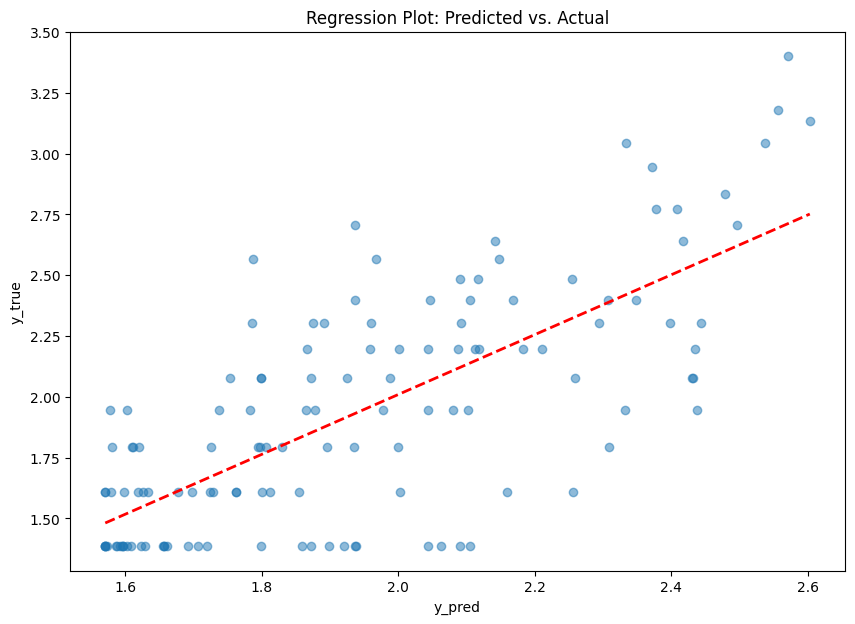

In [272]:
plt.figure(figsize=(10, 7))

ax = sns.regplot(
    x=y_pred2425,
    y=y_test,
    ci=False,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red', 'linestyle': '--', 'linewidth': 2}
)
ax.set_title("Regression Plot: Predicted vs. Actual")
ax.set_xlabel("y_pred")
ax.set_ylabel("y_true")


In [263]:
residulas2425 = y_test - y_pred2425

Text(0.5, 0, 'Residuals')

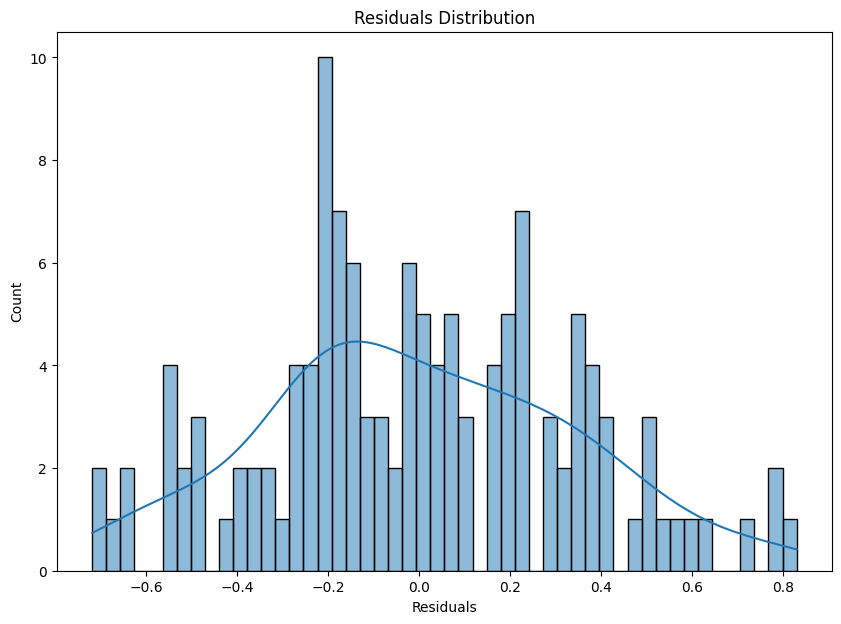

In [276]:
plt.figure(figsize=(10, 7))
ax=sns.histplot(
    data=residulas2425,
    bins=50,
    kde=True
)
ax.set_title("Residuals Distribution")
ax.set_xlabel("Residuals")

Text(0.5, 1.0, 'QQ-plot for Residuals')

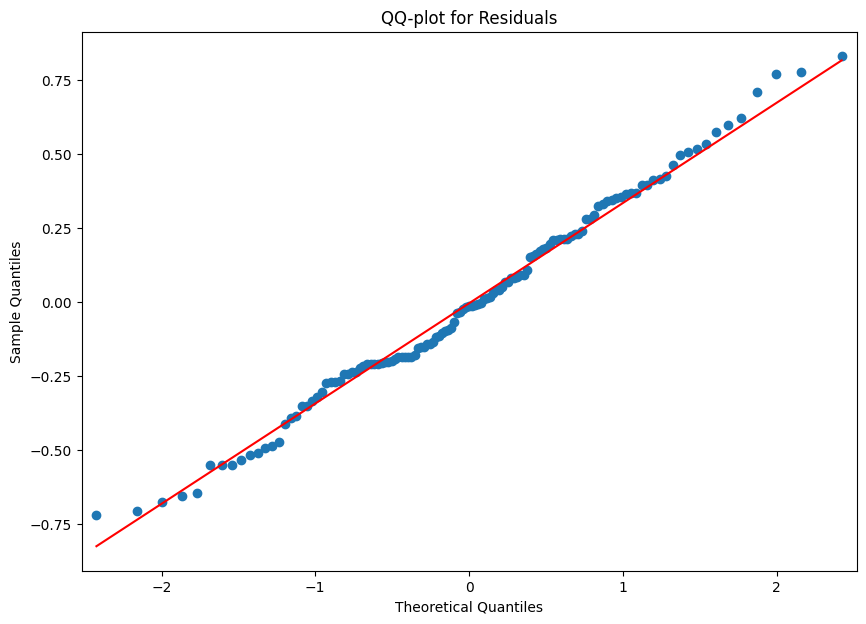

In [279]:
sm.qqplot(residulas2425, line='s').set_size_inches(10, 7)
plt.title("QQ-plot for Residuals")

Text(0.5, 1.0, 'Homoscedasticity Check:')

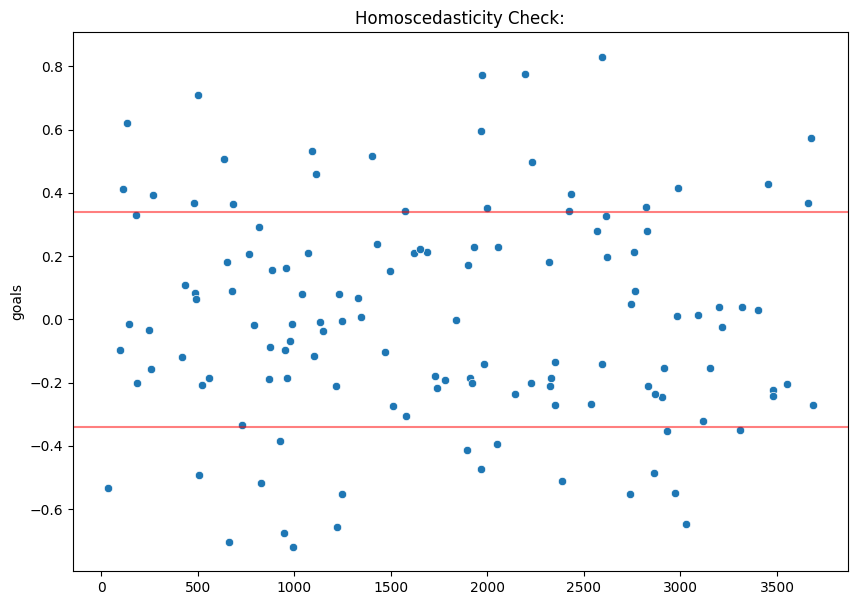

In [280]:
plt.figure(figsize=(10, 7))
ax =sns.scatterplot(
    residulas2425
)
ax.axhline(y=residulas2425.std(), color="r", alpha=0.5)
ax.axhline(y=-residulas2425.std(), color="r", alpha=0.5)
ax.set_title("Homoscedasticity Check")


> **Alternative Feature Engineering:**
> * In this approach, all historical **features (X)** were transformed to reflect performance *only* within the **first 11 gameweeks** (creating stats like `goals_11` or `xg_11`).
> * The **target variable (y)**, however, remained the *total* number of goals scored by the end of that season.
> * This was done to align the training data with the current 25/26 season—where we only have feature data from the 11 matches played so far—to predict the final goal tally.


In [178]:
top_scorers_2526 = df[df.season==2526][["player", "goals"]]
top_scorers_2526.sort_values(by="goals", ascending=False).head(10)

,player,goals
1091,erling haaland,14.0
3384,thiago,8.0
817,danny welbeck,6.0
266,antoine semenyo,6.0
1687,jean-philippe mateta,6.0
501,bryan mbeumo,5.0
1518,jaidon anthony,4.0
3545,viktor gyokeres,4.0
3643,wilson isidor,4.0
2738,nick woltemade,4.0


In [208]:
train = df['season'].isin([2425])

X_case1_train = df[train][case_1]
X_case2_train = df[train][case_2]

y_train = df[train]['goals']

In [222]:
df11 = df.copy()

In [223]:
df11['goals_11'] = (df11['goals']/ df11['matches'].replace(0, np.nan)).fillna(0) * 11
df11['xg_11'] = (df11['xg'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11
df11['np_goals_11'] = (df11['np_goals'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11
df11['np_xg_11'] = (df11['np_xg'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11

df11['assists_11'] = (df11['assists'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11
df11['xa_11'] = (df11['xa'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11

df11['shots_11'] = (df11['shots'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11
df11['key_passes_11'] = (df11['key_passes'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11

df11['minutes_11'] = (df11['minutes'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11

df11['yellow_11'] = (df11['yellow_cards'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11
df11['red_11'] = (df11['red_cards'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11

df11['xg_chain_11'] = (df11['xg_chain'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11
df11['xg_buildup_11'] = (df11['xg_buildup'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11


In [224]:
y = df11.goals
y_train = y[train].apply(np.log1p)


In [225]:
X_2526 = df[df.season==2526]
X_2526_case1 = X_2526[case_1]
X_2526_case2 = X_2526[case_2]


In [226]:
rf_case1.fit(X_case1_train, y_train)
cat_case1.fit(X_case1_train, y_train)
lr_pipe_case1.fit(X_case1_train, y_train);
lasso_pipe_case1.fit(X_case1_train, y_train);


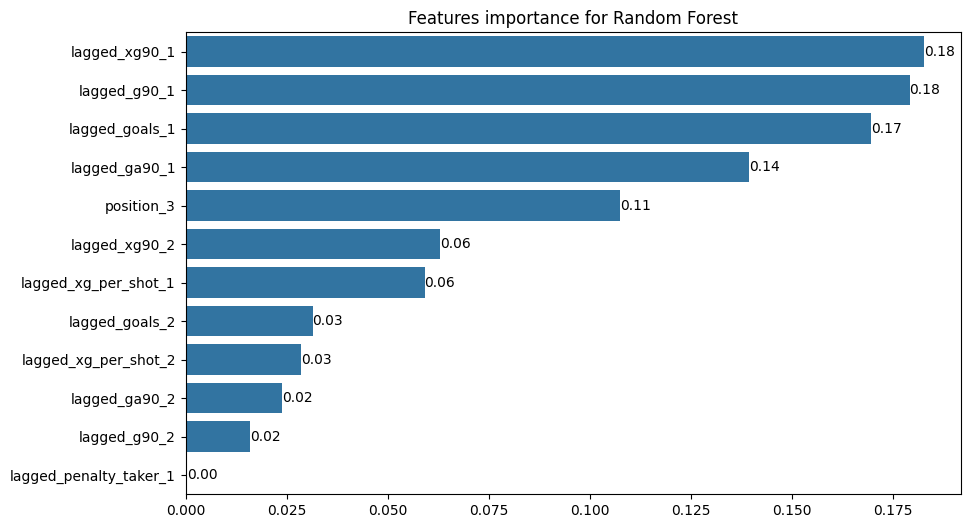

In [282]:
best_features = pd.Series(rf_case1.feature_importances_, index=df[case_1].columns)

plt.figure(figsize=(10, 6))
ax=sns.barplot(data= best_features.sort_values(ascending=False),
            orient="h",
            estimator="sum",
            errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10, fmt="%.2f");
plt.title("Features importance for Random Forest");

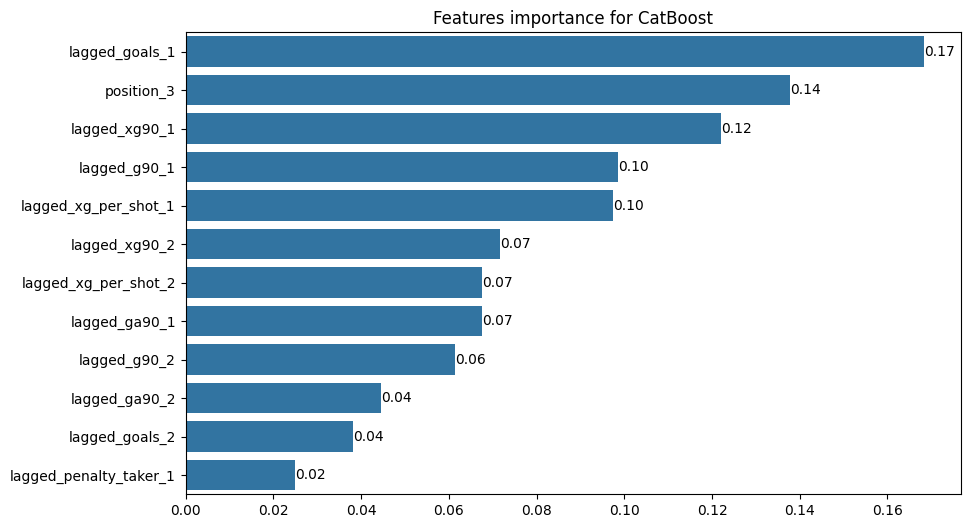

In [228]:
best_features = pd.Series(cat_case1.feature_importances_/100, index=df[case_1].columns)

plt.figure(figsize=(10, 6))
ax=sns.barplot(data= best_features.sort_values(ascending=False),
            orient="h",
            estimator="sum",
            errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10, fmt="%.2f");
plt.title("Features importance for CatBoost");

In [229]:
y_pred_rf = pd.Series(rf_case1.predict(X_2526_case1), name="rf_predictions", index = X_2526.index).apply(np.expm1)
y_pred_cat = pd.Series(cat_case1.predict(X_2526_case1), name="cat_predictions", index = X_2526.index).apply(np.expm1)
y_pred_lr = pd.Series(lr_pipe_case1.predict(X_2526_case1), name="lr_predictions", index = X_2526.index).apply(np.expm1)
y_pred_lasso = pd.Series(lasso_pipe_case1.predict(X_2526_case1), name="ridge_predictions", index = X_2526.index).apply(np.expm1)


In [230]:
rf_eval = pd.concat([X_2526.player, y_pred_rf], axis=1).sort_values(by="rf_predictions", ascending=False).head(10).reset_index(drop=True).drop(columns="rf_predictions", axis=1)

In [231]:
cat_eval = pd.concat([X_2526.player, y_pred_cat], axis=1).sort_values(by="cat_predictions", ascending=False).head(10).reset_index(drop=True).drop(columns="cat_predictions", axis=1)

In [232]:
lr_eval = pd.concat([X_2526.player, y_pred_lr], axis=1).sort_values(by="lr_predictions", ascending=False).head(10).reset_index(drop=True).drop(columns="lr_predictions", axis=1)

In [234]:
ridge_eval = pd.concat([X_2526.player, y_pred_lasso], axis=1).sort_values(by="ridge_predictions", ascending=False).head(10).reset_index(drop=True).drop(columns="ridge_predictions", axis=1)

In [235]:
models_eval = pd.concat([rf_eval, cat_eval, lr_eval, ridge_eval], axis=1)
models_eval.columns = ["rf", "cat", "lr", "ridge"]
models_eval.index = range(1, models_eval.shape[0]+1)
models_eval

,rf,cat,lr,ridge
1,erling haaland,erling haaland,erling haaland,mohamed salah
2,mohamed salah,jean-philippe mateta,mohamed salah,erling haaland
3,jean-philippe mateta,mohamed salah,jean-philippe mateta,bryan mbeumo
4,bryan mbeumo,joão pedro,jarrod bowen,jean-philippe mateta
5,richarlison,danny welbeck,bryan mbeumo,jarrod bowen
6,joão pedro,kevin schade,danny welbeck,kevin schade
7,donyell malen,bryan mbeumo,joão pedro,antoine semenyo
8,jarrod bowen,jarrod bowen,kevin schade,joão pedro
9,kevin schade,richarlison,donyell malen,cody gakpo
10,danny welbeck,nick woltemade,ismaila sarr,danny welbeck


> # Top Scorers Forecast 25/26
> * **The Unanimous Favorite:**
>     Three of the four models (Random Forest, CatBoost, and Linear Regression) predict **Erling Haaland** as the primary candidate to win the top scorer title at the end of the season.
>
> * **Confirmation from actual data (GW11):**
>     This forecast is supported by the current results. After 11 matches, Haaland already has 14 goals, giving him a significant lead over the rest of the field (second place is Thiago with 8 goals).
>
>
> * **Strong Podium Contenders:**
>     Besides Haaland and Salah, **Jean-Philippe Mateta** is consistently forecasted in the top three by most models, making him a strong contender for a high finish at the end of the season.
>
> * **Others in the Top 10:**
>     Players such as Bryan Mbeumo, João Pedro, Jarrod Bowen, and Danny Welbeck also appear regularly in the Top 10 forecasts, confirming their strong position in the race.